# House Prices

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Convert categorical data to numerical representation, and replace 'NaN' with 0

In [3]:
train_n = pd.get_dummies(train)
train_n = train_n.fillna(0)
train_np = train_n.drop(['SalePrice'], axis=1)

test_n = pd.get_dummies(test)
test_n = test_n.fillna(0)

Use `SelectKBest` with ANOVA F-value to select best features to use as predictors

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif, chi2

predictors = train_np.columns.tolist()

selector = SelectKBest(f_classif, k=15)
selector.fit(train_np[predictors], train_n['SalePrice'])

# Replace infinity values with 1
scores = -np.log10(selector.pvalues_)
scores[scores == np.inf] = 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


In [5]:
len(predictors) == len(scores)

True

Select best features based on p-value higher than the mean and sort the data frame

In [13]:
best_features = pd.DataFrame(scores.tolist(), index=predictors)
bf_mean = best_features.mean().tolist()[0]

bf_overall = best_features.loc[best_features[0] > bf_mean]
bf_overall = bf_overall.sort_values(by=0, ascending=0)
bf_predictors = bf_overall.index.tolist()

Plot the best features (p-value > mean) on a barchart 

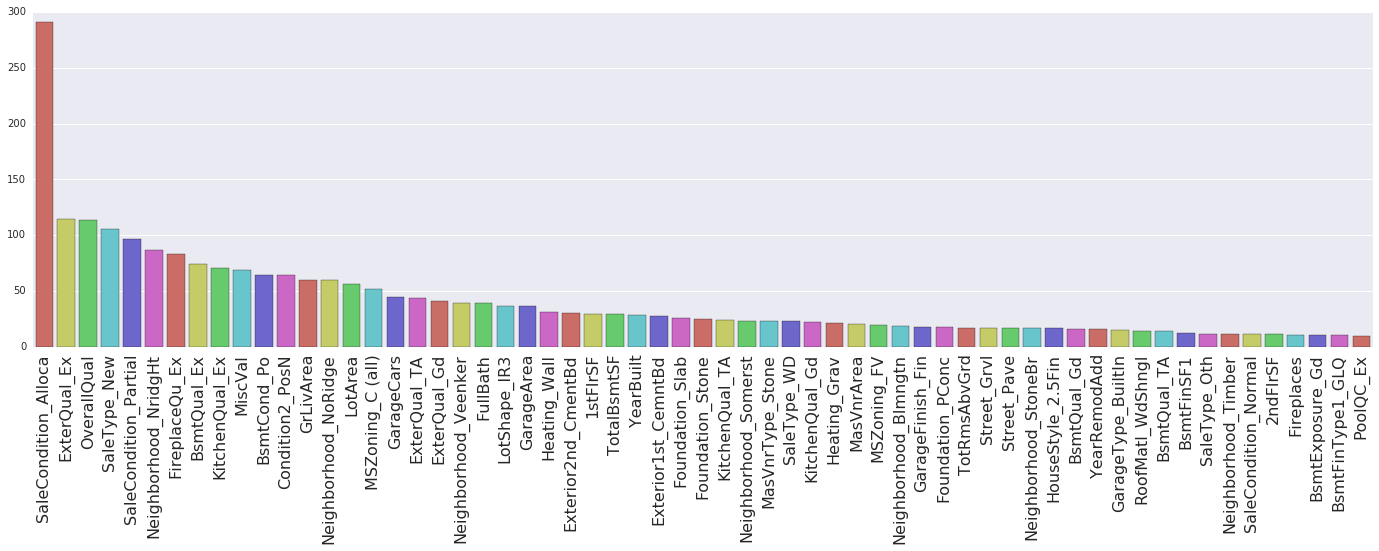

In [14]:
plt.figure(figsize=(24,6))
sns.barplot(list(range(len(bf_predictors))), bf_overall.values.flatten(), palette=sns.color_palette('hls'))
plt.xticks(list(range(len(bf_predictors))), bf_predictors, rotation='vertical', fontsize=16);

Use RandomForestRegressor with cross validation to calculate it's score, using only the features that scored above the mean from the `SelectKBest` function:

In [16]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=25,
                          n_jobs=-1)

scores = cross_validation.cross_val_score(rf, train_np[bf_predictors],
                                         train_n['SalePrice'],
                                         cv=3)

print(np.mean(scores))

0.858950286485


Since the `get_dummies()` function was used that introduces columns for each categorical variable, some columns in the train data will not be present in the test data after applying the same function on it. Thus, the best features found earlier that are not present in the test data are dropped, giving rise to the new `test_bf` feature predictors.

In [18]:
import copy
test_features = test_n.columns.tolist()
test_bf = copy.copy(bf_predictors)

for feature in bf_predictors:
    if feature not in test_features:
        test_bf.remove(feature)

In [19]:
rf.fit(train_np[test_bf], train_n['SalePrice'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [20]:
predictions = rf.predict(test_n[test_bf])

In [221]:
submission = pd.DataFrame(predictions,index=test_n['Id'], columns=['SalePrice'])

In [222]:
submission.to_csv('predictions.csv')

Correlation matrix of features in data set using only best features:

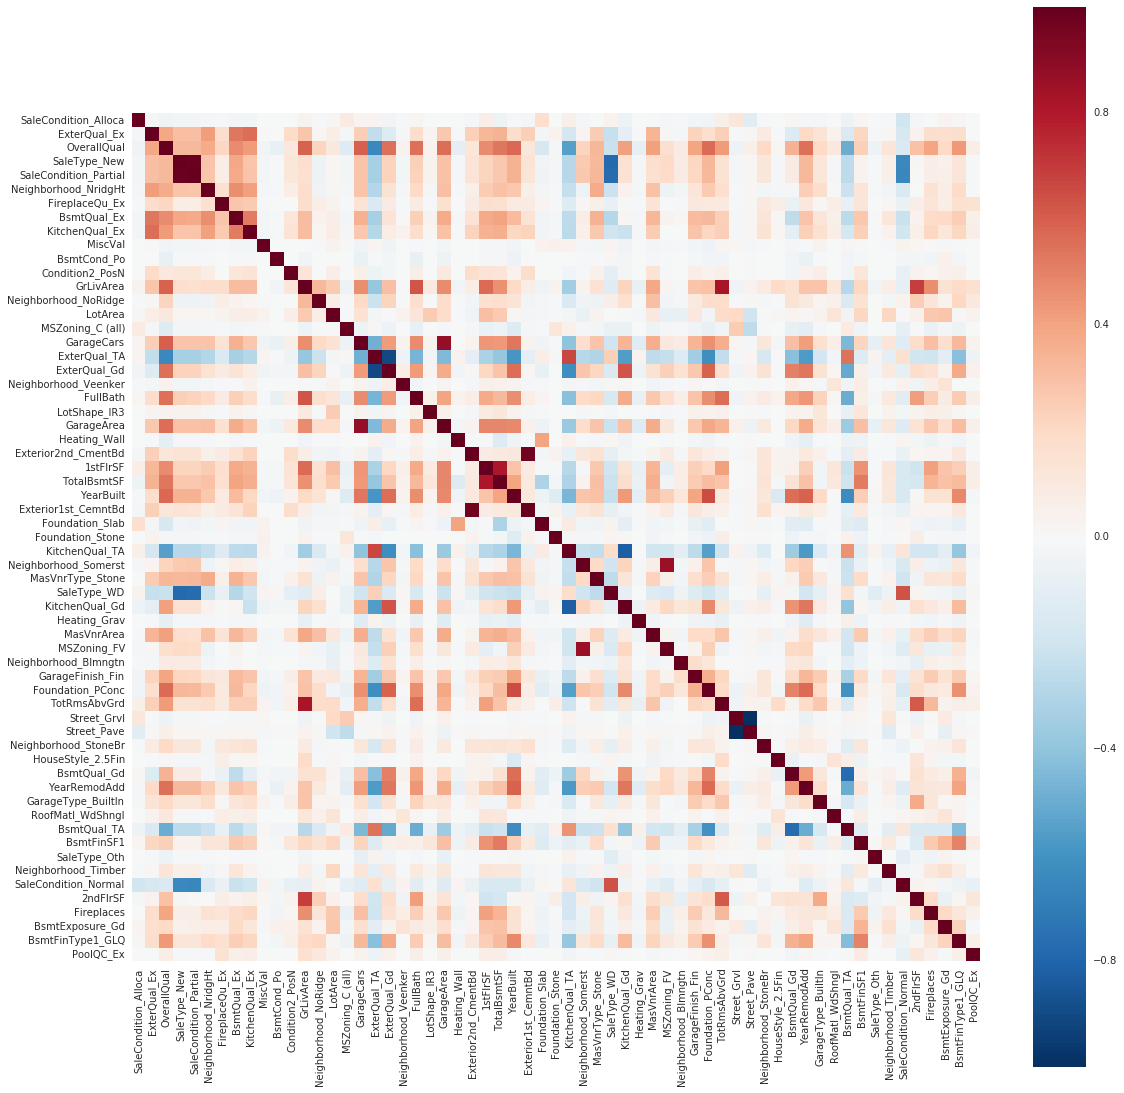

In [21]:
corr = train_n[bf_predictors].corr()
plt.figure(figsize=(19,19))
sns.heatmap(corr, vmax=1, square=True)

In [22]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

/opt/conda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [23]:
pipe = Pipeline(steps=[('rf', RandomForestRegressor())])

In [24]:
est = GridSearchCV(pipe,
                  dict(
        rf__n_estimators=[5,10,15,20,25,50,75],
        rf__min_samples_split=[2, 3, 4, 5, 10]),
                   n_jobs=-1, verbose=3, cv=3)

In [25]:
est.fit(train_np[bf_predictors], train_n['SalePrice'])

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.785491 -   0.1s
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.848271 -   0.1s
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.830431 -   0.1s
[CV]  rf__min_samples_split=2, rf__n_estimators=10, score=0.874746 -   0.1s
[CV] rf__min_samples_split=2, rf__n_estimators=15 ....................
[CV] rf__min_samples_split=2, rf__n_estimators=15 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=10, score=0.789823 - 

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.6s


[CV]  rf__min_samples_split=10, rf__n_estimators=10, score=0.880025 -   0.1s
[CV] rf__min_samples_split=10, rf__n_estimators=10 ...................
[CV]  rf__min_samples_split=10, rf__n_estimators=10, score=0.835571 -   0.1s
[CV] rf__min_samples_split=10, rf__n_estimators=10 ...................
[CV]  rf__min_samples_split=5, rf__n_estimators=50, score=0.822720 -   0.4s
[CV] rf__min_samples_split=5, rf__n_estimators=75 ....................
[CV]  rf__min_samples_split=10, rf__n_estimators=10, score=0.810447 -   0.1s
[CV] rf__min_samples_split=10, rf__n_estimators=15 ...................
[CV]  rf__min_samples_split=5, rf__n_estimators=50, score=0.890091 -   0.5s
[CV] rf__min_samples_split=5, rf__n_estimators=50 ....................
[CV]  rf__min_samples_split=10, rf__n_estimators=15, score=0.886661 -   0.1s
[CV] rf__min_samples_split=10, rf__n_estimators=15 ...................
[CV]  rf__min_samples_split=10, rf__n_estimators=15, score=0.840033 -   0.1s
[CV] rf__min_samples_split=10, rf__n_

[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    6.2s remaining:    0.4s


[CV]  rf__min_samples_split=5, rf__n_estimators=75, score=0.823331 -   0.5s
[CV]  rf__min_samples_split=10, rf__n_estimators=75, score=0.849489 -   0.4s


[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    6.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__min_samples_split': [2, 3, 4, 5, 10], 'rf__n_estimators': [5, 10, 15, 20, 25, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [26]:
est.best_params_

{'rf__min_samples_split': 5, 'rf__n_estimators': 75}

In [27]:
est.grid_scores_

[mean: 0.82142, std: 0.02641, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 5},
 mean: 0.83618, std: 0.03510, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 10},
 mean: 0.85533, std: 0.01637, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 15},
 mean: 0.85689, std: 0.01220, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 20},
 mean: 0.85613, std: 0.01241, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 25},
 mean: 0.85742, std: 0.01767, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 50},
 mean: 0.85800, std: 0.01877, params: {'rf__min_samples_split': 2, 'rf__n_estimators': 75},
 mean: 0.82084, std: 0.02670, params: {'rf__min_samples_split': 3, 'rf__n_estimators': 5},
 mean: 0.84393, std: 0.02175, params: {'rf__min_samples_split': 3, 'rf__n_estimators': 10},
 mean: 0.85670, std: 0.01605, params: {'rf__min_samples_split': 3, 'rf__n_estimators': 15},
 mean: 0.84934, std: 0.02286, params: {'rf__min_samples_split': 3, 'rf__n_estimato

In [28]:
est.fit(train_np[test_bf], train_n['SalePrice'])

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=5 .....................
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.853528 -   0.1s
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.793616 -   0.0s
[CV]  rf__min_samples_split=2, rf__n_estimators=5, score=0.835254 -   0.1s
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV] rf__min_samples_split=2, rf__n_estimators=10 ....................
[CV] rf__min_samples_split=2, rf__n_estimators=15 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=10, score=0.877647 -   0.1s
[CV] rf__min_samples_split=2, rf__n_estimators=15 ....................
[CV]  rf__min_samples_split=2, rf__n_estimators=10, score=0.856202 - 

[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    5.0s


[CV]  rf__min_samples_split=5, rf__n_estimators=50, score=0.832206 -   0.5s
[CV] rf__min_samples_split=5, rf__n_estimators=75 ....................
[CV]  rf__min_samples_split=5, rf__n_estimators=50, score=0.848199 -   0.4s
[CV] rf__min_samples_split=10, rf__n_estimators=5 ....................
[CV]  rf__min_samples_split=10, rf__n_estimators=5, score=0.850272 -   0.0s
[CV] rf__min_samples_split=10, rf__n_estimators=5 ....................
[CV]  rf__min_samples_split=5, rf__n_estimators=75, score=0.849663 -   0.7s
[CV] rf__min_samples_split=5, rf__n_estimators=75 ....................
[CV]  rf__min_samples_split=10, rf__n_estimators=5, score=0.832927 -   0.0s
[CV] rf__min_samples_split=10, rf__n_estimators=5 ....................
[CV]  rf__min_samples_split=10, rf__n_estimators=5, score=0.785878 -   0.0s
[CV] rf__min_samples_split=10, rf__n_estimators=10 ...................
[CV]  rf__min_samples_split=4, rf__n_estimators=75, score=0.831617 -   0.7s
[CV] rf__min_samples_split=5, rf__n_estima

[Parallel(n_jobs=-1)]: Done  98 out of 105 | elapsed:    6.5s remaining:    0.5s


[CV]  rf__min_samples_split=10, rf__n_estimators=50, score=0.886874 -   0.3s
[CV]  rf__min_samples_split=10, rf__n_estimators=75, score=0.887523 -   0.5s
[CV] rf__min_samples_split=10, rf__n_estimators=75 ...................
[CV]  rf__min_samples_split=10, rf__n_estimators=50, score=0.843806 -   0.3s
[CV]  rf__min_samples_split=10, rf__n_estimators=75, score=0.839478 -   0.5s
[CV]  rf__min_samples_split=10, rf__n_estimators=75, score=0.855706 -   0.4s


[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    7.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__min_samples_split': [2, 3, 4, 5, 10], 'rf__n_estimators': [5, 10, 15, 20, 25, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [29]:
est.score(train_np[test_bf], train_n['SalePrice'])

0.97432142853401871

In [30]:
gs_predict = est.predict(test_n[test_bf])

In [31]:
gs_submission = pd.DataFrame(gs_predict,index=test_n['Id'], columns=['SalePrice'])

In [32]:
gs_submission.to_csv('gs_subm.csv')